The following cell contains code for inputting and processing data

In [2]:
import argparse
import pdb
import os 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

from utils import *
from config import *

import warnings
warnings.filterwarnings("ignore")

def feature_engineer(dset,train=True):
    activities = ["No_documents","Social_media_views","No_inquiry","Calls_by_Gartner_sd","No_meetings","No_symposiums","Conferences","Testimonials"]
    cap_columns = ["No_documents","Social_media_views","No_inquiry"]
    for col in cap_columns:
        for month in range(12):
            col_ = col+" TP "+str(month)
            col_val = dset[col_]
            quantile = 1 if col_val.quantile(0.98)==0 else col_val.quantile(0.98)
            col_val = np.array([quantile if val>quantile  else val for val in col_val ])
#             col_val = np.log(col_val+1)
            dset[col_] = col_val
            
    for col in activities:
        for month in range(12):
            col_ = col+" TP "+str(month)
            dset[col_] = dset[col_]/dset[col_].max()
    return dset

In [3]:
def predict(train_dset, test_dset, train_target, model_name, args, client_id):

	if model_name is "svr":
		from sklearn.svm import LinearSVC
		method = LinearSVC(max_iter = 10000, tol=1e-6)
	elif model_name is "svc":
		from sklearn.svm import SVC
		method = SVC( tol= 1e-6)
	elif model_name is "grad_boost":
		from sklearn.ensemble import GradientBoostingClassifier as GBC
		method = GBC(learning_rate = 0.05, n_estimators=1000, max_depth = 8, tol =1e-6)
	method.fit(train_dset,train_target)
	targets = method.predict(test_dset)

	os.makedirs("Results", exist_ok = True)
	result = pd.DataFrame({"Client ID":client_id,"Client Retention Flag":targets})
	result = result.replace({1:"Yes",0:"No"}) 
	result.to_csv('Results/' + args.save_fname +'.csv',index = None, header = True)
	print("Finished Predicting and Creating file")

def process_dset(dset, args, train = True):
	"""Function to do feature engineering. All data processing is done here.
	   Takes in a raw dataset and outputs processed dataset."""
	
	if train:
		# Remove columns with more than threshold% of null values
		dset = remove_null(dset, threshold = 0.4, verbose = False)

	# Rename column names
	dset = rename_fields(dset, dictionary = FIELD_DICTIONARY)

	# Replace column containing texts with numbersINDUSTRY_DICT = {'Manufacturing':1, 'Government':2, 'Technology and Telecom':3,'Banking, Finance & Ins':4, 'Education':5, 'Energy & Utilities':6, 'Healthcare':7, 'Services':8, 'Retail':9, 'Unknown':10}

	dict_list = [STARTING_MONTH_DICT,SUBSCRIPTION_DICT,INQUIRY_DICT,ONBOARDED_DICT,INDUSTRY_DICT]
	dset = replace_col_vals(dset, dict_list)

# 	# Remove unncecessary columns
	try:
		# Inside try block since "Client ID" field will be already removed in case of test dataset
		del dset["Client ID"]
	except:
		pass
	del dset["Company ID"]
	
	# # Remove columns with more than threshold correlation
	# dset = remove_correlation(dset, threshold = args.threshold, verbose = True)	

	return dset

filename = "Dataset/Train.csv"

# Get a pandas dataframe object from csv file
dset= pd_df_from_csv(filename, sampled = False, train = True, colname = "Client Retention Flag" , split_target_ = False)

# # Check the data
# print(dset.head())

# Process / Clean-up the dataset
dset = process_dset(dset = dset, args = None, train = True )


# Do feature Engineering
dset = feature_engineer(dset = dset, train = True)	
crf = "Client Retention Flag"

Size of dataset (before splitting target) :  (8766, 106)


# Q. Which months are most important for client engagement for driving higher retention?

Assumption : Engagement involves All activities

In [4]:
retained_dset  = dset[dset[crf]==1]
not_retained_dset  = dset[dset[crf]==0]
cols = ['No_documents','Social_media_views','No_inquiry','Calls_by_Gartner_sd','No_meetings','No_symposiums','Conferences','Testimonials']
fields = cols.append("Month")
cols.remove("Month")
array_ret = np.zeros((12,len(cols)+1))
array_not_ret = np.zeros((12,len(cols)+1))
for month in range(12):
    array_ret[month][-1] = int(month)
    array_not_ret[month][-1] = int(month)
    for i,col in enumerate(cols):
        array_ret[month,i] = retained_dset[col+" TP "+str(month)].mean()
        array_not_ret[month,i] = not_retained_dset[col+" TP "+str(month)].mean()
monthly_ret = pd.DataFrame(data = array_ret,columns = cols + ["Month"])
monthly_not_ret = pd.DataFrame(data = array_not_ret,columns = cols + ["Month"])
# monthly_df.columns 
# for i in range(len(cols)):
#     print("PLOT FOR ",cols[i])
#     plt.figure()    
#     sns.barplot(x = 'Month',y = cols[i], data =monthly_df)
# plt.figure()
# sns.barplot(x = 'Month',y = cols[0], hue= [cols[i] for i in range(1,len(cols))], data =monthly_df)

In [8]:
dset.columns

Index(['Client Contract Starting Month', 'Subscription', 'Service_category',
       'Inquiry_eligibility', 'Onboarded', 'Region', 'Industry',
       'No_documents TP 11', 'No_documents TP 10', 'No_documents TP 9',
       ...
       'Testimonials TP 8', 'Testimonials TP 7', 'Testimonials TP 6',
       'Testimonials TP 5', 'Testimonials TP 4', 'Testimonials TP 3',
       'Testimonials TP 2', 'Testimonials TP 1', 'Testimonials TP 0',
       'Client Retention Flag'],
      dtype='object', length=104)

In [20]:
dset['No_documents TP 0'].mean()

0.11269159770186246

<Axes: xlabel='No_documents TP 11', ylabel='Probability'>

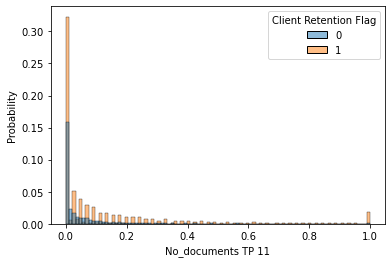

In [34]:
sns.histplot(x = 'No_documents TP 11', hue = 'Client Retention Flag', data = dset, stat='probability')
# plt.ylim([0,1])

<Axes: xlabel='Client Contract Starting Month', ylabel='Count'>

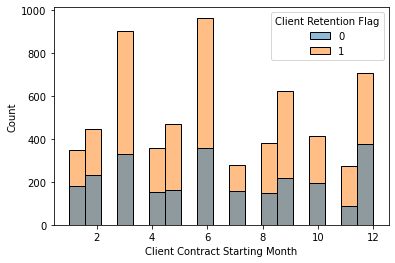

In [27]:
import seaborn as sns

# sns.barplot(x = 'Client Contract Starting Month', y = 'Client Retention Flag', data = dset)
# plt.ylim([0,1])

sns.histplot(x = 'Client Contract Starting Month', hue = 'Client Retention Flag', data = dset)
# plt.ylim([0,1])

In [5]:
# # dset.plot(x=crf, y=['Conferences TP 8'], kind="bar")
# colors = ['r','g','b','c','m','y','k','w','r','g','b','c','m','y','k','w']
# plt.figure(figsize = (10,10))
# for i in range (len(cols)):
#     plt.bar(monthly_df["Month"] + i*0.05, monthly_df[cols[i]]/max( monthly_df[cols[i]]), color = colors[i], width = 0.05)
# # plt.bar(monthly_df["Month"] + 0.25, monthly_df[cols[1]], color = 'g', width = 0.25)
# # plt.bar(dset[crf] + 0.50, data[2], color = 'r', width = 0.25)
# plt.show()

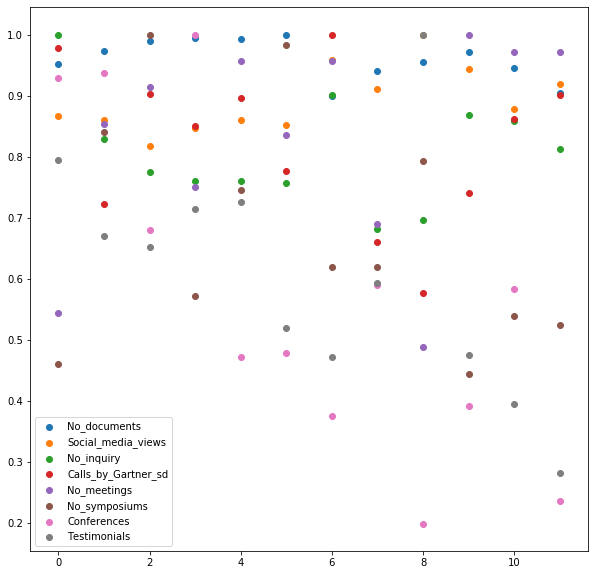

In [36]:
plt.figure(figsize = (10,10))
for col in cols:
    plt.scatter(monthly_ret["Month"], y = monthly_ret[col]/max(monthly_ret[col]))
plt.legend(cols)
plt.show()

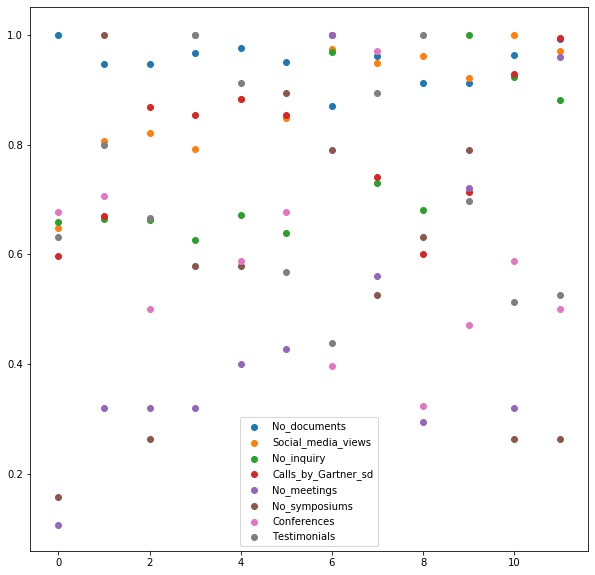

In [37]:
plt.figure(figsize = (10,10))
for col in cols:
    plt.scatter(monthly_not_ret["Month"], y = monthly_not_ret[col]/max(monthly_not_ret[col]))
plt.legend(cols)
plt.show()

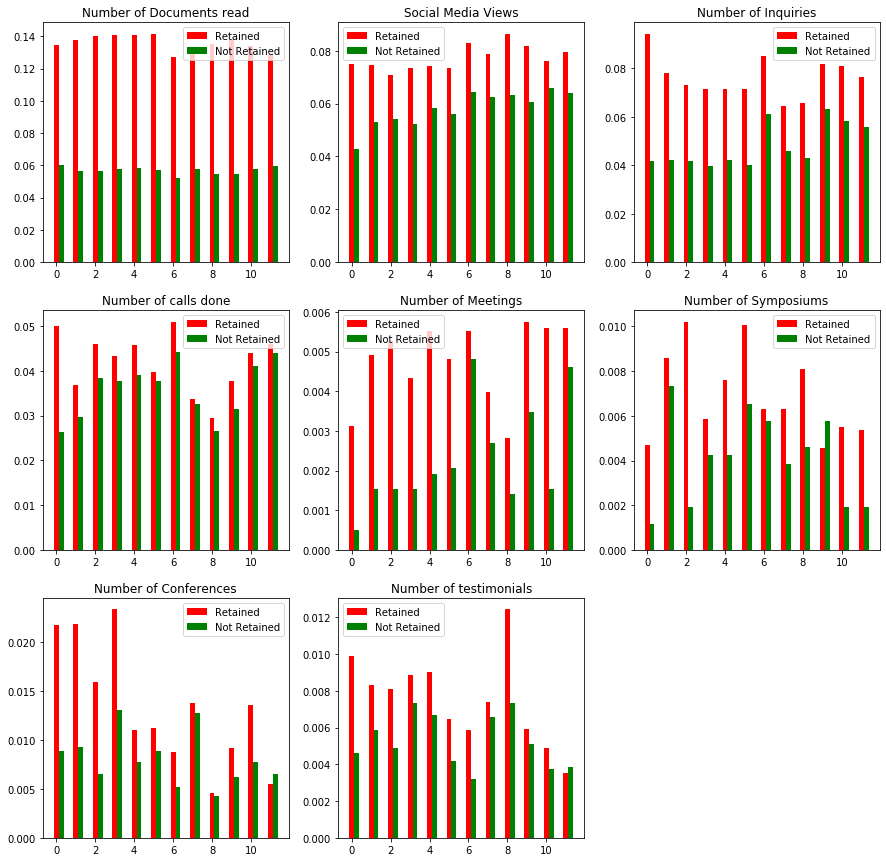

In [38]:
# dset.plot(x=crf, y=['Conferences TP 8'], kind="bar")
proper_col_names = ["Number of Documents read","Social Media Views","Number of Inquiries","Number of calls done","Number of Meetings","Number of Symposiums","Number of Conferences","Number of testimonials"]
colors = ['r','g','b','c','m','y','k','w','r','g','b','c','m','y','k','w']
plt.figure(figsize = (15,15))
for i in range (len(cols)):
    plt.subplot(3,3,i+1)
    plt.bar(monthly_ret["Month"] + 0.00, monthly_ret[cols[i]], color = colors[0], width = 0.25)
    plt.bar(monthly_not_ret["Month"] + 0.25, monthly_not_ret[cols[i]], color = colors[1], width = 0.25)
    plt.title(proper_col_names[i])
    plt.legend(["Retained","Not Retained"])
plt.show()

Observations : (correct? all other factors constant?) - TRY WITH SINGLE AND MULTI YEAR SUBSCRIPTION

->Clients who retained contracts seems to be more engaged in the initial months. Once the trust is gained, then peace.
->Significantly higher number of meetings with retained clients in the first five months(around 2 to 5 times).
->Number of calls done by Gartner Service desk are almost twice in first month for first month.
-> Twice Social media views in first month.
->Total number of engagements are always higher for retained clients.

=> Try to gain trust in first month

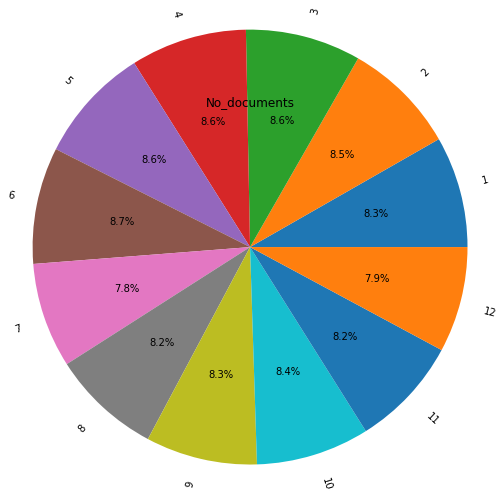

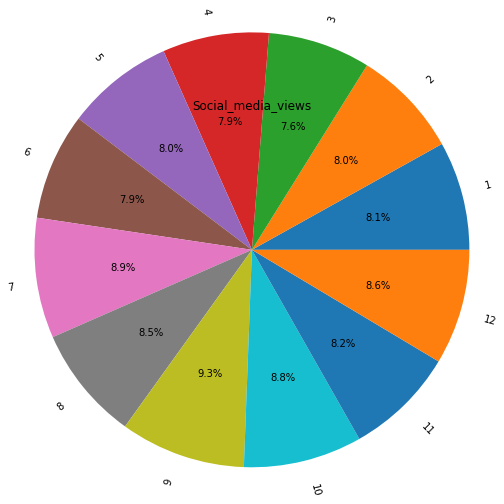

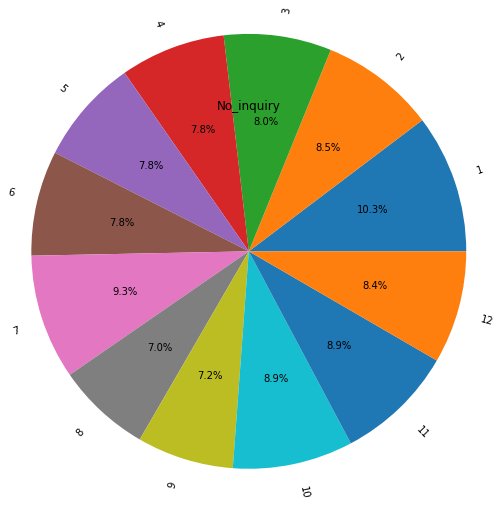

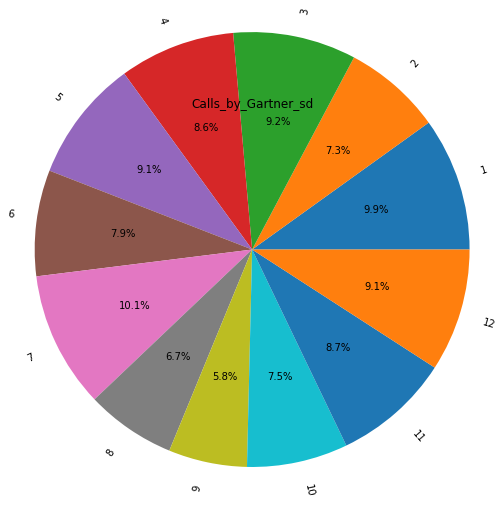

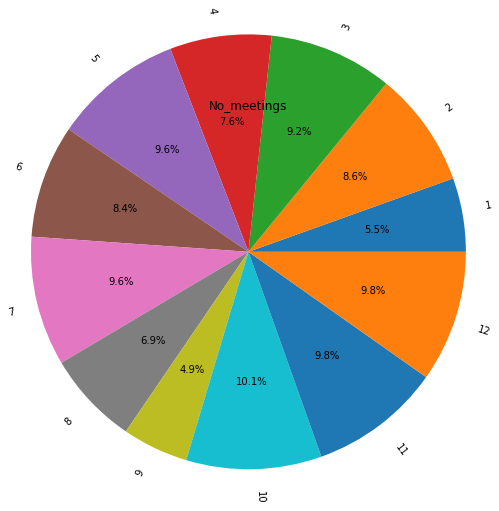

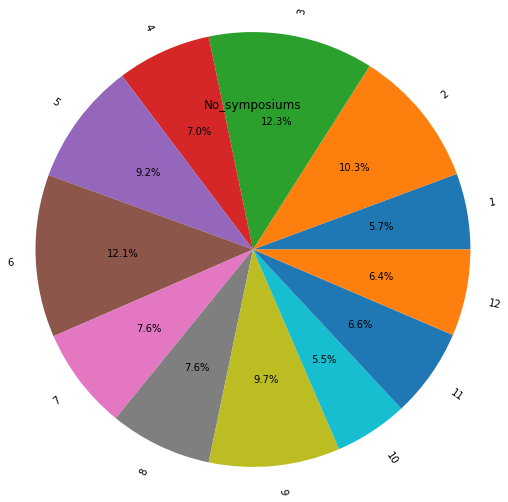

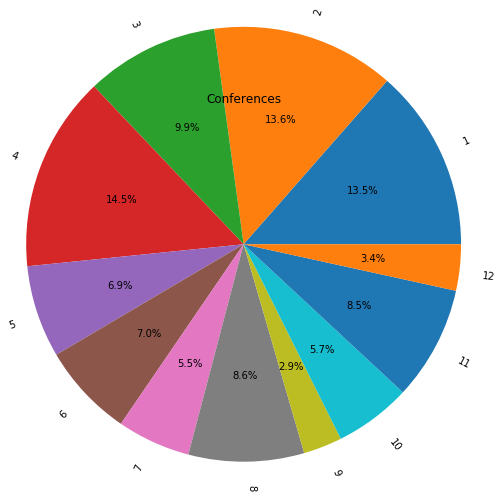

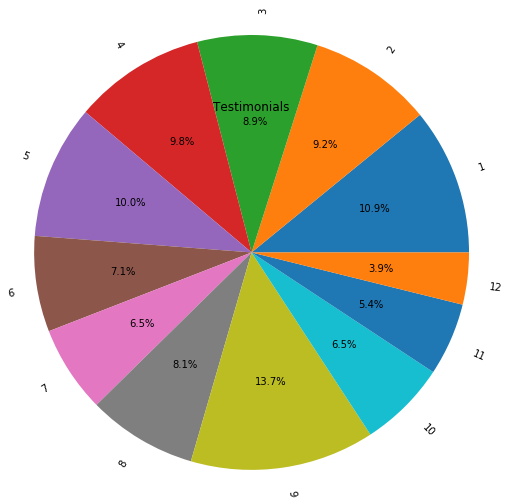

In [39]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct)

# plt.figure(figsize =  (10,10))
for i in range(0,len(monthly_ret.columns)-1):
    #     plt.subplot(6,6,2*i+1)
    plt.figure(figsize =  (5,5))
    data = monthly_ret[monthly_ret.columns[i]]*100
    plt.pie(data,labels = list(range(1,13)),radius=2,autopct=lambda pct: func(pct, data),wedgeprops = {'linewidth': 10},rotatelabels=True )
    #     plt.setp(autotexts, size=8, weight="bold")
    plt.title(monthly_ret.columns[i])
plt.show()
# print(monthly_ret)
# print(monthly_ret[monthly_ret.columns[7]])
# data = monthly_ret[monthly_ret.columns[7]]*10
# plt.pie(data,labels = list(range(1,13)),radius=2,wedgeprops = {'linewidth': 10},rotatelabels=True )

# Q. What activities should service associate recommend in first month to drive higher engagement in subsequent months?

96
0.0
23.0


(array([7.762e+03, 5.370e+02, 2.240e+02, 1.510e+02, 4.600e+01, 2.200e+01,
        1.500e+01, 4.000e+00, 4.000e+00, 1.000e+00]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

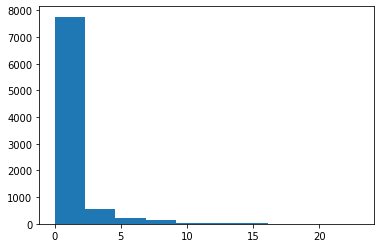

In [51]:
cols = ['No_documents','Social_media_views','No_inquiry','Calls_by_Gartner_sd','No_meetings','No_symposiums','Conferences','Testimonials']
extractable_columns = [x+" TP "+str(j) for x in cols for j in range(12) ]
first_month_dset = pd.DataFrame(dset[extractable_columns], columns = extractable_columns)
print(len(first_month_dset.columns))

# Define 'Engagement' in future months
first_month_dset["Engagement"] = np.zeros((first_month_dset.shape[0],1))
# engagement_columns = [x+" TP "+str(j) for x in cols for j in range(1,12) ]
# for col in engagement_columns:
#     first_month_dset["Engagement"] += np.array(first_month_dset[col]/first_month_dset[col].max())
# print(len(first_month_dset.columns))
engagement_columns = [x+" TP "+str(j) for x in cols for j in range(1,12) ]
for col in engagement_columns:
    col_val = first_month_dset[col].astype('int64')
    quantile = 1 if col_val.quantile(0.95)==0 else col_val.quantile(0.95)
    col_val = np.array([quantile if val>quantile  else val for val in col_val ])
    col_val = col_val/col_val.max()
    first_month_dset["Engagement"] += col_val
print(first_month_dset['Engagement'].min())
print(first_month_dset['Engagement'].max())
plt.hist(first_month_dset['Engagement'])

In [52]:
col = first_month_dset['Engagement']
# quantile_25 = col.quantile(0.25)
quantile_50 = col.quantile(0.5)
# quantile_75 = col.quantile(0.75)
# quantile_80 = col.quantile(0.8)

first_month_dset['Engagement_bin'] = pd.cut(x=first_month_dset['Engagement'], bins=[0-1,quantile_50,int(col.max())+1], labels=[1,2])
print(len(first_month_dset.columns))
for column in [col for col in first_month_dset.columns if col not in ['Engagement_bin']]:
    if "0" in column and "1" not in column:
        print(column,"\t Mean ",np.round(first_month_dset[column].mean(),4),"\t Mean when Engagement_bin is 4 or 5 :",np.round(first_month_dset[column][(first_month_dset['Engagement_bin']==2) ].mean(),4))
        try:
            print(column,"\t\t ratio",np.round(float(first_month_dset[column][(first_month_dset['Engagement_bin']==2)].mean())/float(first_month_dset[column].mean()),4))
        except:
            print("ZERO DIVISON ERROR - ",column)
        # first_month_dset[first_month_dset.columns[0]][first_month_dset['Engagement_bin']==5].mean()
first_month_dset["Engagement_bin"] = first_month_dset["Engagement_bin"].astype('int64')
print(first_month_dset["Engagement_bin"].mean())

98
No_documents TP 0 	 Mean  0.1127 	 Mean when Engagement_bin is 4 or 5 : 0.1824
No_documents TP 0 		 ratio 1.6184
Social_media_views TP 0 	 Mean  0.0654 	 Mean when Engagement_bin is 4 or 5 : 0.1044
Social_media_views TP 0 		 ratio 1.5961
No_inquiry TP 0 	 Mean  0.0787 	 Mean when Engagement_bin is 4 or 5 : 0.1502
No_inquiry TP 0 		 ratio 1.9099
Calls_by_Gartner_sd TP 0 	 Mean  0.043 	 Mean when Engagement_bin is 4 or 5 : 0.0487
Calls_by_Gartner_sd TP 0 		 ratio 1.134
No_meetings TP 0 	 Mean  0.0024 	 Mean when Engagement_bin is 4 or 5 : 0.0031
No_meetings TP 0 		 ratio 1.3188
No_symposiums TP 0 	 Mean  0.0037 	 Mean when Engagement_bin is 4 or 5 : 0.0051
No_symposiums TP 0 		 ratio 1.3937
Conferences TP 0 	 Mean  0.0179 	 Mean when Engagement_bin is 4 or 5 : 0.0215
Conferences TP 0 		 ratio 1.1994
Testimonials TP 0 	 Mean  0.0083 	 Mean when Engagement_bin is 4 or 5 : 0.0105
Testimonials TP 0 		 ratio 1.2643
1.403604836869724


It can be observed that Social media views (10), Inquiries(8.507), Meetings(5.43) and Document(8.61) have  higher value in 1st month whenever they have high engagement throughout the year. Thus it is always better to promote these events. (Questionable: it should work the other way, in a particular category of meeting(say), does it have higher probability for high engagement or low engagement )

In [53]:
print(len(first_month_dset.columns))
bins = [1,2,3]
for column in first_month_dset.columns:
    if ("0" in column and "1" not in column) and ("Engagement" not in column):
        col_value = first_month_dset[column]
        col_max = max(col_value)
        median = first_month_dset[column][first_month_dset[column]>0].quantile(0.5)
        first_month_dset[column+"_bin_"] = pd.cut(x=col_value, bins=[0-1,median,col_max+1], labels=[1,2])

print(first_month_dset["Social_media_views TP 0_bin_"].isna().sum())
print(len(list(first_month_dset.columns)))

98
0
106


In [54]:
bins = [1,2]
for col_ in first_month_dset.columns:
    if ("Engagement" not in col_) and ("_bin" in col_):#(first_month_dset[col].dtype.name is "category"):
        for bin_ in bins:
            higher_count = first_month_dset[col_][(((first_month_dset["Engagement_bin"]==2)) & (first_month_dset[col_]==bin_))].count()
            total_bin_count = first_month_dset[col_][first_month_dset[col_]==bin_].count()
            if total_bin_count !=0:
                ratio = higher_count*100/ total_bin_count
                print(col_,"\t BIN :",bin_,"\t Percentage of higher Engagement : ",ratio)
            else:
                ratio = 0
                print(col_,"\t BIN :",bin_,"\t total bin count : ",total_bin_count)

No_documents TP 0_bin_ 	 BIN : 1 	 Percentage of higher Engagement :  32.33022207917605
No_documents TP 0_bin_ 	 BIN : 2 	 Percentage of higher Engagement :  59.91379310344828
Social_media_views TP 0_bin_ 	 BIN : 1 	 Percentage of higher Engagement :  38.07328015952144
Social_media_views TP 0_bin_ 	 BIN : 2 	 Percentage of higher Engagement :  65.09433962264151
No_inquiry TP 0_bin_ 	 BIN : 1 	 Percentage of higher Engagement :  38.45603149982102
No_inquiry TP 0_bin_ 	 BIN : 2 	 Percentage of higher Engagement :  81.81818181818181
Calls_by_Gartner_sd TP 0_bin_ 	 BIN : 1 	 Percentage of higher Engagement :  39.79812545061284
Calls_by_Gartner_sd TP 0_bin_ 	 BIN : 2 	 Percentage of higher Engagement :  50.9009009009009
No_meetings TP 0_bin_ 	 BIN : 1 	 Percentage of higher Engagement :  40.32239625014291
No_meetings TP 0_bin_ 	 BIN : 2 	 Percentage of higher Engagement :  57.89473684210526
No_symposiums TP 0_bin_ 	 BIN : 1 	 Percentage of higher Engagement :  40.360483686972394
No_symposiu

Based on the above data, it is advisable if cusomers ask more inquiries (32%), service calls from Gartner(21%) and meetings(21%) and social media views(19%) and No of document (18%)

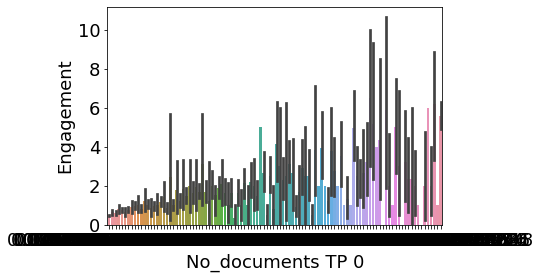

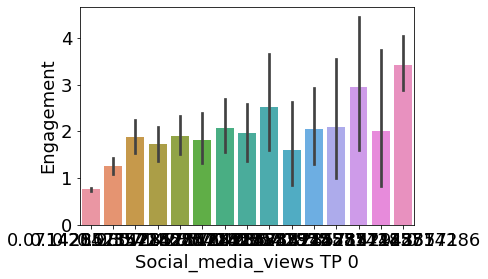

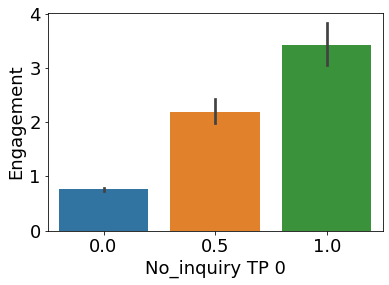

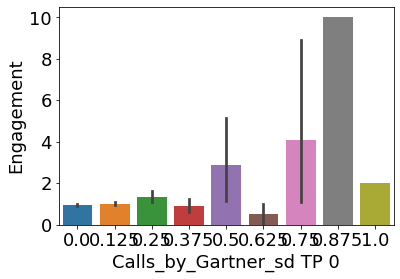

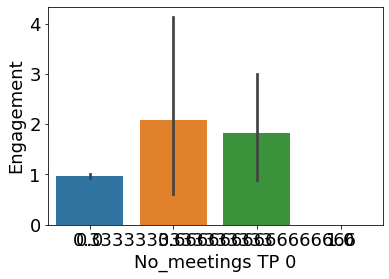

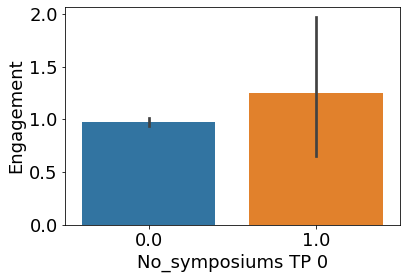

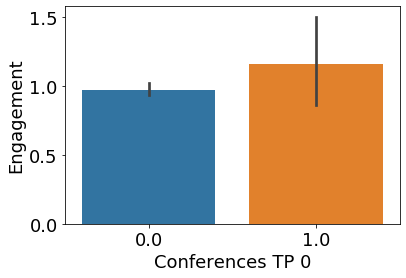

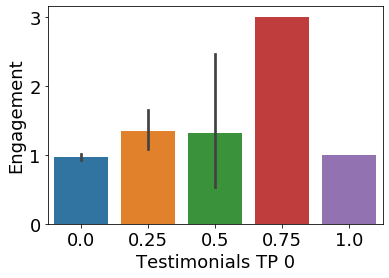

In [153]:
for col_ in first_month_dset.columns:
    if (("Engagement" not in col_) and (" TP 0" in col_)) and ("bin" not in col_):#(first_month_dset[col].dtype.name is "category"):
        plt.figure()
        sns.barplot(first_month_dset[col_],first_month_dset["Engagement"])
# first_month_dset["Engagement_bin"].astype('int64').mean()

# Q. What are the most important activities that will impact client retention?

In [56]:
cols = ['No_documents','Social_media_views','No_inquiry','Calls_by_Gartner_sd','No_meetings','No_symposiums','Conferences','Testimonials']
extractable_columns = [x+" TP "+str(j) for x in cols for j in range(12) ] +["Client Retention Flag"]
# impact_dset = dset[extractable_columns]
from scipy.stats import  boxcox
print(dset.shape)
impact_dset = dset.copy()

for column in impact_dset.columns:
    if "_bin_" in column:
        del impact_dset[column]
bins = [1,2,3]
for column in impact_dset.columns:
    col_value = impact_dset[column]
    col_max = max(col_value)
    median = impact_dset[column][impact_dset[column]>0].quantile(0.5)
    impact_dset[column+"_bin_"] = pd.cut(x=col_value, bins=[0-1,median,col_max+1], labels=[1,2])

(8766, 104)


In [57]:
columns = ["No_documents","Social_media_views","No_inquiry","Calls_by_Gartner_sd","No_meetings","No_symposiums","Conferences","Testimonials"]
range_of_months = 12
for col in columns:
    for i in range(range_of_months-1):
        # dset[col+"_diff_"+str(i)] = dset[col+"_sum_"+str(i+1)] - dset[col+"_sum_"+str(i)]
        impact_dset[col+"_diff_"+str(i)] = impact_dset[col+" TP "+str(i+1)] - impact_dset[col+" TP "+str(i)]
print(impact_dset.shape)        
for month in range(12):
    impact_dset["Engagement_in_month_"+str(month)] = np.zeros((impact_dset.shape[0],1))
    for col in columns:        
        col_val = impact_dset[col+" TP "+str(month)].astype('int64')
        quantile = 1 if col_val.quantile(0.95)==0 else col_val.quantile(0.95)
        col_val = np.array([quantile if val>quantile  else val for val in col_val ])
        col_val = col_val/col_val.max()
        impact_dset["Engagement_in_month_"+str(month)] += col_val
print(impact_dset.shape)        
for col in columns:
    impact_dset["Engagement_in_activity_"+str(col)] = np.zeros((impact_dset.shape[0],1))
    for month in range(12):
        col_val = impact_dset[col+" TP "+str(month)].astype('int64')
        quantile = 1 if col_val.quantile(0.95)==0 else col_val.quantile(0.95)
        col_val = np.array([quantile if val>quantile  else val for val in col_val ])
        col_val = col_val/col_val.max()
        impact_dset["Engagement_in_activity_"+str(col)] += col_val
print(impact_dset.shape)        
dict_abs_month = {}
for index, row in impact_dset.iterrows():
    month = row["Client Contract Starting Month"]
    for i in range(12):
        try:
            dict_abs_month[(month+i)%12].append(row["Engagement_in_month_"+str(i)])
        except:
            dict_abs_month[(month+i)%12] = []
            dict_abs_month[(month+i)%12].append(row["Engagement_in_month_"+str(i)])
for key,value in dict_abs_month.items():
    impact_dset["Engagement_in_abs_month_"+str(key)] = np.array(value)
print(impact_dset.shape)

(8766, 296)
(8766, 308)
(8766, 316)
(8766, 328)


Text(0.5, 1.0, 'Influence of Activities in Client Retention')

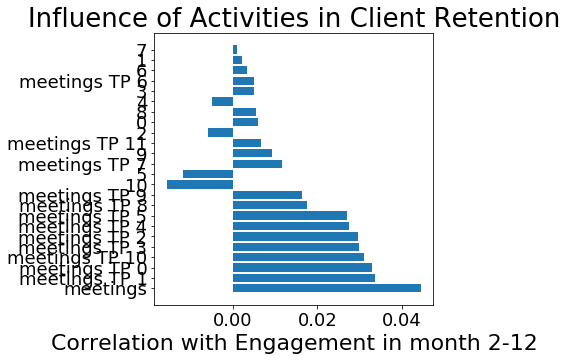

In [188]:
plt.rcParams.update({'font.size': 18})
# print(impact_dset[crf].corr(impact_dset["Testimonials TP 10"], method="kendall"))
# print(impact_dset[crf].corr(impact_dset["Testimonials TP 10"], method="spearman"))
# print(impact_dset[crf].corr(impact_dset["Testimonials TP 10"], method="pearson"))
# impact_dset["Eng_in_sub_months"] = np.zeros((impact_dset.shape[0],1))
# for month in range(1,12): 
#     impact_dset["Eng_in_sub_months"] += impact_dset["Engagement_in_month_"+str(month)]
corr_1 = impact_dset.corr( method="pearson")[crf]
corr_ = corr_1[[corr_1.index[i] for i in range(len(corr_1.index)) if "meetings" in corr_1.index[i]  ]]
# corr_dict  = {corr_.index[i] : corr_[corr_.index[i]] for i in range(len(corr_.index)) if "Engagement_in" in corr_.index[i]}
sorted_corr_ = sorted(corr_.iteritems(), key = lambda x : abs(x[1]), reverse =True)[0:50]
# [x,y] = [a,b for a,b ]
plt.figure(figsize=(5,5))
tick_label  = ["DOCUMENTS","CALLS BY GARTNER","INQUIRY","SOCIAL MEDIA VIEWS","TESTIMONIALS","CONFERENCES","MEETINGS","SYMPOSIUMS"]
plt.barh([ x[0].split('_')[-1] for x in sorted_corr_],[ x[1] for x in sorted_corr_])#, tick_label =tick_label)
plt.xlabel("Correlation with Engagement in month 2-12", fontsize = 22)
# plt.ylabel("Activities", fontsize = 20)
plt.title("Influence of Activities in Client Retention", fontsize=26)
# print(sorted_corr_)

Engagement in First month has highest correlation => Most relevant
No: of Documents - leading activity - no big difference throughout the month

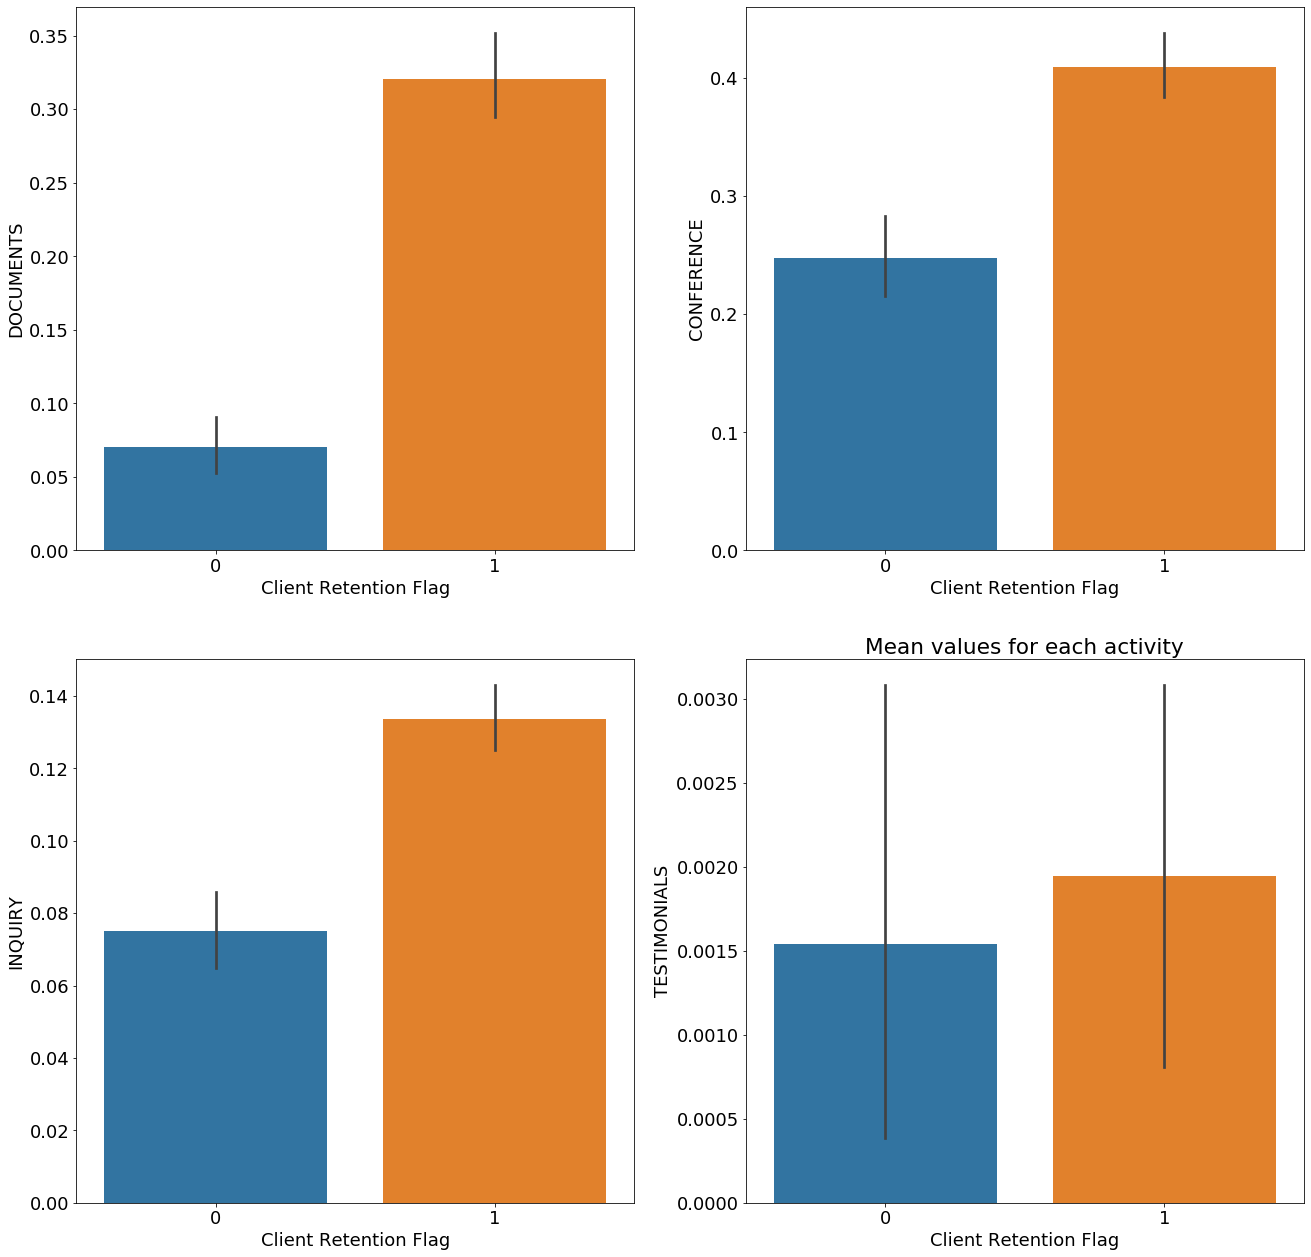

In [129]:
plt.figure(figsize= (22,22))
plt.rcParams.update({'font.size': 18})
impact_dset.rename(columns=name_dict, inplace=True)
name = ["DOCUMENTS","INQUIRY","CONFERENCE","TESTIMONIALS"]
count = 0
lst = ["Engagement_in_activity_No_documents","Engagement_in_activity_Conferences",'Engagement_in_activity_No_inquiry',"Engagement_in_activity_Testimonials"]
for col in impact_dset.columns:
    if col in name:
        count += 1
        plt.subplot(2,2,count)
#         plt.figure()
        sns.barplot(impact_dset[crf],impact_dset[col])
#         plt.ylabel  = ("Mean value (with error)")

plt.show()
        

In [17]:

            
#         row["Engagement_in_abs_month_"+str((month+i)%12)] = row["Engagement_in_month_"+str(i)]
# #     impact_dset.loc[index] = row
#     print(index)
    

In [18]:
for col in impact_dset.columns:
    if "month" in col:
        abs_month = impact_dset["Client Contract Starting Month"]
        rel_month = int(col.split('_')[-1])
        print(rel_month)
        print(abs_month)
        final_month = (abs_month+rel_month)%12
        impact_dset["Eng_in_abs_month_"+final_month] = impact_dset[col]

0
0        6
1        3
2       12
3        2
4        6
5        6
6        5
7        7
8       10
9        5
10       5
11       6
12       7
13       9
14       8
15       3
16       5
17       3
18       6
19      12
20       6
21      12
22       3
23       2
24       2
25      11
26       5
27       3
28       2
29       1
        ..
8736     6
8737     5
8738     3
8739     5
8740     9
8741     7
8742     7
8743     5
8744    11
8745     8
8746    12
8747     6
8748    11
8749    10
8750     9
8751     9
8752     8
8753    12
8754     9
8755     5
8756     7
8757     6
8758     6
8759     6
8760    11
8761    12
8762     5
8763     7
8764     6
8765     6
Name: Client Contract Starting Month, Length: 8766, dtype: int64


TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U21') dtype('<U21') dtype('<U21')

In [ ]:
for index, row in impact_dset.iterrows():
    pass

In [116]:
name_dict = {key:value for key,value in zip(lst,name)}

dset.columns

In [159]:
list(impact_dset.columns)

['Client Contract Starting Month',
 'Subscription',
 'Service_category',
 'Inquiry_eligibility',
 'Onboarded',
 'Region',
 'Industry',
 'No_documents TP 11',
 'No_documents TP 10',
 'No_documents TP 9',
 'No_documents TP 8',
 'No_documents TP 7',
 'No_documents TP 6',
 'No_documents TP 5',
 'No_documents TP 4',
 'No_documents TP 3',
 'No_documents TP 2',
 'No_documents TP 1',
 'No_documents TP 0',
 'Social_media_views TP 11',
 'Social_media_views TP 10',
 'Social_media_views TP 9',
 'Social_media_views TP 8',
 'Social_media_views TP 7',
 'Social_media_views TP 6',
 'Social_media_views TP 5',
 'Social_media_views TP 4',
 'Social_media_views TP 3',
 'Social_media_views TP 2',
 'Social_media_views TP 1',
 'Social_media_views TP 0',
 'No_inquiry TP 11',
 'No_inquiry TP 10',
 'No_inquiry TP 9',
 'No_inquiry TP 8',
 'No_inquiry TP 7',
 'No_inquiry TP 6',
 'No_inquiry TP 5',
 'No_inquiry TP 4',
 'No_inquiry TP 3',
 'No_inquiry TP 2',
 'No_inquiry TP 1',
 'No_inquiry TP 0',
 'Calls_by_Gartner_

In [ ]:
impact_dset.head()

In [ ]:
dset[crf].value_counts()

In [ ]:
6170/2596

In [ ]:
# %matplotlib tk
# plt.figure(figsize=(10,10))
# plt.hist(dset["No_documents TP 9"])
# plt.title("No of Documents in Time Period 9")
# plt.xlabel("Number o")
# # for col in dset.columns:
# #     plt.figure(figsize=(4,4))
# #     plt.hist(dset[col])
# #     plt.title(col)

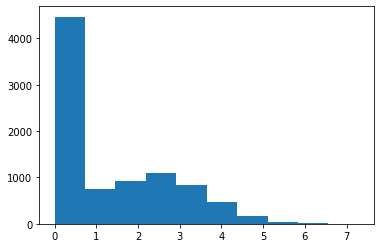

In [35]:
col = dset["No_documents TP 11"]
col = np.log(col+1)
plt.hist(col)
plt.show()

In [25]:
for col in dset.columns:
    print(col,"\t \t",dset[col].corr(dset[crf]))

Client ID 	 	 0.10255748805023451
Company ID 	 	 -0.07808026661862771
Client Contract Starting Month 	 	 -0.006397909451996952
Subscription 	 	 -0.049840671459026833
Service_category 	 	 -0.011721378358458866
Inquiry_eligibility 	 	 0.03727972604741066
Onboarded 	 	 -0.03447650488812742
Region 	 	 0.03434034198369017
Industry 	 	 0.0009478458328355778
No_documents TP 11 	 	 0.10710432765876024
No_documents TP 10 	 	 0.06763787032962269
No_documents TP 9 	 	 0.13401946042415702
No_documents TP 8 	 	 0.1368814048119627
No_documents TP 7 	 	 0.13025602514878148
No_documents TP 6 	 	 0.13431442063986618
No_documents TP 5 	 	 0.1489189003321007
No_documents TP 4 	 	 0.14082423989478018
No_documents TP 3 	 	 0.1446339921655683
No_documents TP 2 	 	 0.14597589948386863
No_documents TP 1 	 	 0.13872074981792057
No_documents TP 0 	 	 0.11424389652124609
Social_media_views TP 11 	 	 0.026319899846816878
Social_media_views TP 10 	 	 0.025362197424299102
Social_media_views TP 9 	 	 0.0280574174997

In [206]:
months = [i for i in range(12)]
testimonials = ["Testimonials TP "+str(month)for month in months]
test_array = np.zeros((not_retained_dset.shape[0],1))
for t in testimonials:
    test_array+= np.array(not_retained_dset[t]).reshape(-1,1)

In [216]:
np.array([test_array>0]).astype('int64').reshape(-1,1)

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [209]:
not_retained_dset.shape

(2596, 104)